**Implement example 6 (Autoencoder) of "module_5_customizeing_fit_function" for image denoising.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

**Dataset:**

In [2]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))

x_test = x_test.astype('float32') / 255.
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

4422102/4422102 [==============================] - 0s 0us/step


**Adding noise:**

In [3]:
# Adding random noise
def noise(x, noise_factor):
    x = x + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=x.shape
    )

    return np.clip(x, 0.0, 1.0)

x_train_noisy = noise(x_train, noise_factor = 0.2)
x_test_noisy = noise(x_test, noise_factor = 0.2)

In [4]:
print(x_train_noisy.shape)
print(x_train.shape)
print(x_test_noisy.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(60000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)


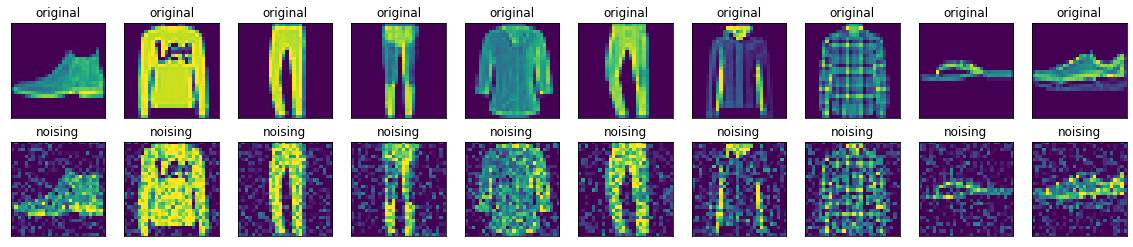

In [7]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

  ax = plt.subplot(2, n, i + 1)
  plt.imshow(tf.squeeze(x_test[i]))
  plt.title('original')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.title('noising')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

**AutoEncoder:**

In [8]:
class Autoencoder(keras.Model):
  def __init__(self):
    super().__init__()

    # Encoder:
    self.encoder = keras.Sequential([layers.Input(shape=(28, 28, 1)),
                                     layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
                                     layers.MaxPooling2D((2, 2), padding='same'),
                                     layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
                                     layers.MaxPooling2D((2, 2), padding='same')])
    
    # Decoder
    self.decoder = keras.Sequential([layers.Conv2DTranspose(128, (3, 3), strides=1, activation='relu', padding='same'),
                                     layers.UpSampling2D((2, 2)),
                                     layers.Conv2DTranspose(128, (3, 3), strides=1, activation='relu', padding='same'),
                                     layers.UpSampling2D((2, 2)),
                                     layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')])
    
    self.loss_tracker = keras.metrics.Mean(name='loss')
    self.binary_crossentropy_metric = keras.metrics.BinaryCrossentropy(name='binary_crossentropy')

  def call(self, data):
    encoder = self.encoder(data)
    decoder = self.decoder(encoder)
    return decoder

  def train_step(self, data):

    # Unpack the data. Its structure depends on your model and
    # on what you pass to `fit()`.
    x, y = data

    with tf.GradientTape() as tape:
      
      # Forward pass
      y_pred = self.encoder(x, training=True)
      reconstruction = self.decoder(y_pred, training=True)

      # Compute the loss value
      # (the loss function is configured in `compile()`)
      loss = keras.losses.binary_crossentropy(y, reconstruction)

    # Compute gradients
    gradients = tape.gradient(loss, self.trainable_variables)

    # Update weights
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    # Compute metrics
    self.loss_tracker.update_state(loss)
    self.binary_crossentropy_metric.update_state(y, reconstruction)

    # Return a dict mapping metric
    return {'loss': self.loss_tracker.result(),
            'binary_crossentropy': self.binary_crossentropy_metric.result()}

  @property
  def metrics(self):
    # We list our `Metric` objects here so that `reset_states()` can be
    # called automatically at the start of each epoch
    # or at the start of `evaluate()`.
    # If you don't implement this property, you have to call
    # `reset_states()` yourself at the time of your choosing.
    return [self.loss_tracker, self.binary_crossentropy_metric]

  def test_step(self, data):

    # Unpack the data
    x, y = data

    # Compute predictions
    y_pred = self.encoder(x, training=False)
    reconstruction = self.decoder(y_pred, training=False)

    # Compute loss
    loss = keras.losses.binary_crossentropy(y, reconstruction) 

    # Compute the metrics
    self.loss_tracker.update_state(loss)
    self.binary_crossentropy_metric.update_state(y, reconstruction)

    # Return a dict mapping metric
    return {'loss': self.loss_tracker.result(),
            "binary_crossentropy": self.binary_crossentropy_metric.result()}

In [9]:
input_layer = Input(shape=(28,28,1))
x = Autoencoder()(input_layer) 
model = Model(inputs=input_layer, outputs=x)
print(model.summary(expand_nested=True))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 autoencoder (Autoencoder)   (None, 28, 28, 1)         445189    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| sequential (Sequential)   (None, 7, 7, 128)         148864    |
||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯||
|| conv2d (Conv2D)         (None, 28, 28, 128)       1280      ||
||                                                             ||
|| max_pooling2d (MaxPooling2D  (None, 14, 14, 128)  0         ||
|| )                                                           ||
||                                                             ||
|| conv2d_1 (Conv2D)       (None, 14, 14, 128)       147584    ||
||                                                           

In [10]:
model = Autoencoder()
model.compile(optimizer=keras.optimizers.Adam())
model.fit(x_train_noisy, x_train, epochs=10, shuffle=True, validation_data = (x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 24s 7ms/step - loss: 0.2742 - binary_crossentropy: 0.2742 - val_loss: 0.2653 - val_binary_crossentropy: 0.2653
Epoch 2/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.2621 - binary_crossentropy: 0.2621 - val_loss: 0.2628 - val_binary_crossentropy: 0.2628
Epoch 3/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.2603 - binary_crossentropy: 0.2603 - val_loss: 0.2620 - val_binary_crossentropy: 0.2620
Epoch 4/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2595 - binary_crossentropy: 0.2595 - val_loss: 0.2612 - val_binary_crossentropy: 0.2612
Epoch 5/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.2589 - binary_crossentropy: 0.2589 - val_loss: 0.2607 - val_binary_crossentropy: 0.2607
Epoch 6/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.2584 - binary_crossentropy: 0.2584 - val_loss: 0.2608 - val_binary_crossentropy: 0.260

In [11]:
denoising_imgs = model(x_test_noisy).numpy()

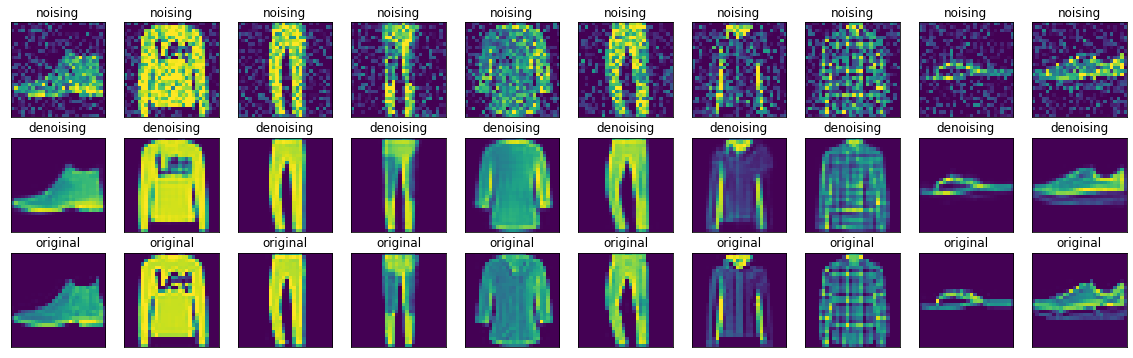

In [12]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):

  ax = plt.subplot(3, n, i + 1)
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.title('noising')
  #plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, i + 1 + n)
  plt.imshow(tf.squeeze(denoising_imgs[i]))
  plt.title('denoising')
  #plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, i + 1 + n + n )
  plt.imshow(tf.squeeze(x_test[i]))
  plt.title('original')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)